In [36]:
import os
import glob
import h5py as h5
import shutil
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from random import random
import random
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import ViTModel
import torch.optim as optim
from Utilities import *


# Paths
data_path = '/home/rbertille/data/pycharm/ViT_project/pycharm_Geoflow/GeoFlow/Tutorial/Datasets/'
dataset_name = 'IntermediateDataset2'
files_path = os.path.join(data_path, dataset_name)

train_folder = glob.glob(f'{files_path}/train/*')
validate_folder = glob.glob(f'{files_path}/validate/*')
test_folder = glob.glob(f'{files_path}/test/*')

class CustomDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.data, self.labels = self.load_data_from_folder(folder)
        self.transform = transform

    def load_data_from_folder(self, folder):
        data = []
        labels = []

        for file_path in folder:
            with h5.File(file_path, 'r') as h5file:
                inputs = h5file['shotgather'][:]
                len_inp = inputs.shape[1]
                half_ind= len_inp//2
                inputs = h5file['shotgather'][:,half_ind:]
                labels_data = h5file['vsdepth'][:]

                #inputs = (inputs - np.min(inputs)) / (np.max(inputs) - np.min(inputs))
                
                transform_tensor = transforms.Compose([
                    transforms.ToTensor()
                ])
                
                
                inputs = transform_tensor(inputs)

                data.append(inputs)
                labels.append(labels_data)

        data = np.array(data)


        labels = np.array(labels)
        return data, labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs = self.data[idx]
        labels = self.labels[idx]

        # Convert inputs and labels to Tensors
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)


        if self.transform:
            inputs = self.transform(inputs)
            
        sample = {'data': inputs, 'label': labels}

        return sample

def create_datasets(data_path, dataset_name):
    train_folder = glob.glob(os.path.join(data_path, dataset_name, 'train', '*'))
    validate_folder = glob.glob(os.path.join(data_path, dataset_name, 'validate', '*'))
    test_folder = glob.glob(os.path.join(data_path, dataset_name, 'test', '*'))

    train_dataset = CustomDataset(train_folder)
    validate_dataset = CustomDataset(validate_folder)
    test_dataset = CustomDataset(test_folder)

    return train_dataset, validate_dataset, test_dataset


train_dataset, validate_dataset, test_dataset= create_datasets(data_path, dataset_name)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [37]:
#prendre un seul exemple dans le train_dataloader
i=0
sample = train_dataloader.dataset[i]
image = sample['data']
label= sample['label']

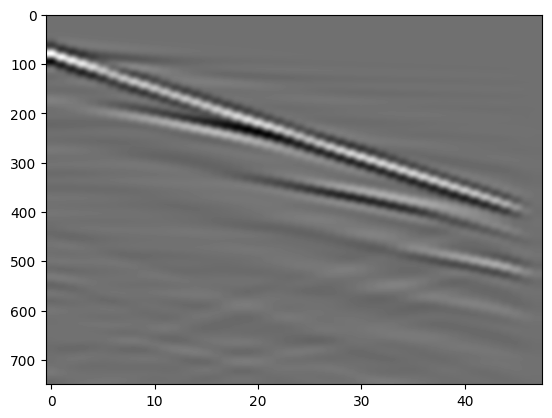

In [38]:
#afficher l'image
plt.imshow(image[0].numpy(),aspect='auto',cmap='gray');plt.show()

In [115]:
#définir les vecteurs d,dt,x,c,fmax:
fmax = 25
dt = 0.00002*100
src_pos=[28.]
rec_pos=np.array([29., 30., 31., 32., 33. ,34. ,35., 36. ,37. ,38., 39., 40., 41., 42., 43. ,44., 45., 46.,
 47., 48., 49., 50. ,51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
 65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76.])
dg = np.abs(rec_pos[0]-rec_pos[1])
off0 = np.abs(rec_pos[0]-src_pos[0])
off1 = np.abs(rec_pos[-1]-rec_pos[0])
ng = rec_pos.shape[-1]
offmin,offmax = np.min([off0,off1]), np.max([off0,off1])
x = rec_pos-src_pos[0]
c = np.logspace(1.5,3.5,num=200) # phase velocities
d = image[0]

In [116]:
c

array([  31.6227766 ,   32.36311014,   33.12077593,   33.89617973,
         34.68973682,   35.5018722 ,   36.33302081,   37.18362776,
         38.05414863,   38.9450496 ,   39.85680782,   40.78991157,
         41.74486059,   42.72216631,   43.72235213,   44.74595369,
         45.79351921,   46.8656097 ,   47.96279933,   49.08567571,
         50.23484021,   51.41090825,   52.61450969,   53.84628914,
         55.10690626,   56.39703621,   57.7173699 ,   59.06861445,
         60.45149354,   61.86674776,   63.31513507,   64.79743116,
         66.31442987,   67.86694366,   69.45580396,   71.08186172,
         72.74598777,   74.44907334,   76.19203053,   77.97579279,
         79.80131543,   81.66957612,   83.5815754 ,   85.53833727,
         87.54090968,   89.59036512,   91.68780118,   93.83434116,
         96.03113466,   98.27935816,  100.58021574,  102.93493961,
        105.34479087,  107.81106013,  110.33506821,  112.91816686,
        115.56173947,  118.26720182,  121.03600284,  123.86962

In [117]:
import tensorflow as tf
import math

def phase_shift_sum_base(d, f, x, c, adjoint=False):
    """
    Apply the phase shift summation to a signal in the frequency domain

    :param d: Data with shape [..., nx, nf] if adjoint is False,
              or [..., nc, nt] if adjoint is True.
    :param f: Frequency vector with nf components
    :param x: A 1D array containing the full offset of the nx traces
    :param c: A 1D array containing the nc velocities
    :param adjoint: If True, goes from the velocity-freq to offset-freq domain,
                    if False, goes from offset-freq to velocity-freq domain.

    :return:
        m: Phase-shifted summation of the signal. If adjoint, the dimensions
           is [..., nx, nf], else is [..., nc, nf]
    """

    nd = tf.rank(d)
    inds = tf.concat([tf.ones(nd-1, dtype=tf.int32), [-1]], axis=0)
    f = tf.cast(tf.reshape(f, inds), d.dtype)

    c = tf.cast(c, d.dtype)
    nc = c.shape[-1]

    inds = tf.concat([tf.ones(nd - 2, dtype=tf.int32), [-1, 1]], axis=0)
    x = tf.cast(x, d.dtype)
    nx = x.shape[-1]

    if adjoint:
        c = tf.reshape(c, inds)
        m = tf.TensorArray(d.dtype, size=nx)
        for ix in tf.range(nx):
            i = tf.cast(tf.complex(0.0, -1.0), d.dtype)
            delta = tf.exp(i * 2 * math.pi * f * x[ix] / c)
            m = m.write(ix, tf.reduce_sum(delta * d, axis=-2))
    else:
        x = tf.reshape(x, inds)
        m = tf.TensorArray(d.dtype, size=nc)
        for ic in tf.range(nc):
            i = tf.cast(tf.complex(0.0, 1.0), d.dtype)
            delta = tf.exp(i * 2 * math.pi * f * x / c[ic])
            m = m.write(ic, tf.reduce_sum(delta * d, axis=-2))

    leading = tf.range(1, nd - 1)
    trailing = tf.constant([-1]) + tf.rank(f)
    new_order = tf.concat([leading, [0], trailing], axis=0)

    return tf.transpose(m.stack(), new_order)

def phase_shift_sum(d, f, x, c, adjoint=False):
    """
    Apply the phase shift summation to a signal in the frequency domain,
    and provide a custom gradient.

    :param d: Data with shape [..., nx, nf] if adjoint is False,
              or [..., nc, nt] if adjoint is True.
    :param f: Frequency vector with nf components
    :param x: A 1D array containing the full offset of the nx traces
    :param c: A 1D array containing the nc velocities
    :param adjoint: If True, goes from the velocity-freq to offset-freq domain,
                    if False, goes from offset-freq to velocity-freq domain.

    :return:
        m: Phase-shifted summation of the signal. If adjoint, the dimensions
           is [..., nx, nf], else is [..., nc, nf]
    """
    dout = phase_shift_sum_base(d, f, x, c, adjoint=adjoint)
    return dout

    # Note: The gradient function is omitted here


def linear_radon_freq(d, dt, x, c, fmax=None, norm=False, epsilon=0.001):

    nt = d.shape[-1]
    d_fft = tf.signal.rfft(d)
    if norm: d_fft /= tf.cast(tf.abs(d_fft) + epsilon*tf.math.reduce_max(tf.abs(d_fft)),dtype=tf.complex64)
    fnyq = 1.00 / (nt*dt) * (nt//2+1)
    if fmax is None:
        fmax = fnyq
    if fmax > fnyq:
        raise ValueError("fmax=%f is greater than nyquist=%f"
                         % (fmax, 0.5 / dt))
    f = tf.range(fmax, delta=1.00 / (nt*dt))
    nf = f.shape[-1]

    d_fft = d_fft[..., :nf]

    # Utilisation uniquement de la sortie de phase_shift_sum
    m = phase_shift_sum(d_fft, f, x, c)

    return m



def dispersion(d, dt, x, c, fmax=None,epsilon=0.001):
    '''
    calculate the dispersion image using phase shift method
    :param d: shotgather
    :param dt: timestep
    :param x: position of the receivers
    :param c: 
    :param fmax: 
    :param epsilon: 
    :return: 
    '''
    return tf.abs(linear_radon_freq(d, dt, x, c, fmax=fmax, norm=True,epsilon=epsilon))



In [118]:
disp = dispersion(d.T, dt, x, c, epsilon=1e-6,fmax=25).numpy().T
#dispers=np.expand_dims((disp-np.min(disp))/(np.max(disp)-np.min(disp)),axis=-1)

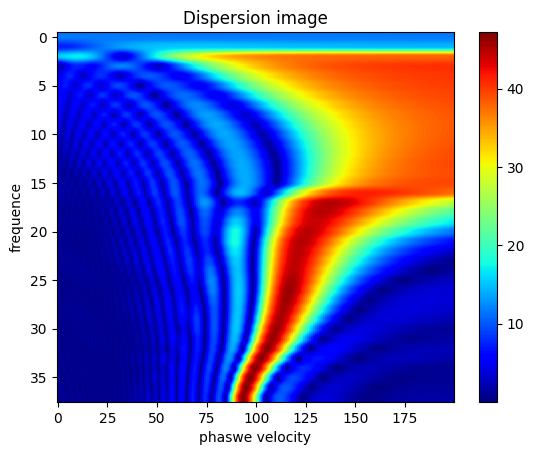

In [119]:
#afficher l'image
#remettre les axes dans les bonnes unités
#affichier l'image dans les bonnes unités
plt.imshow(disp,aspect='auto',cmap='jet')
#labels
plt.xlabel('phaswe velocity')
plt.ylabel('frequence')
plt.title('Dispersion image')
#ajouter une colorbar
plt.colorbar()
plt.show()

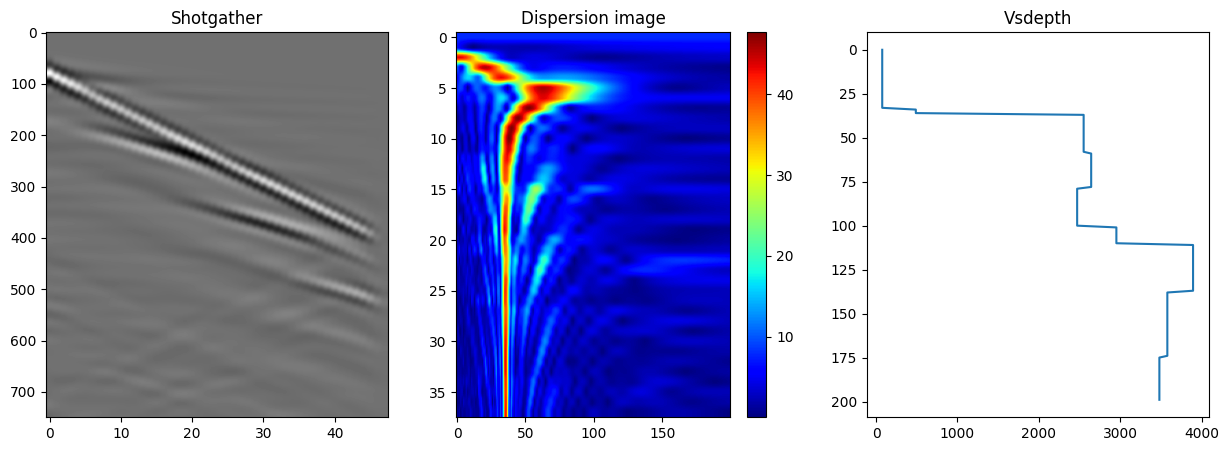

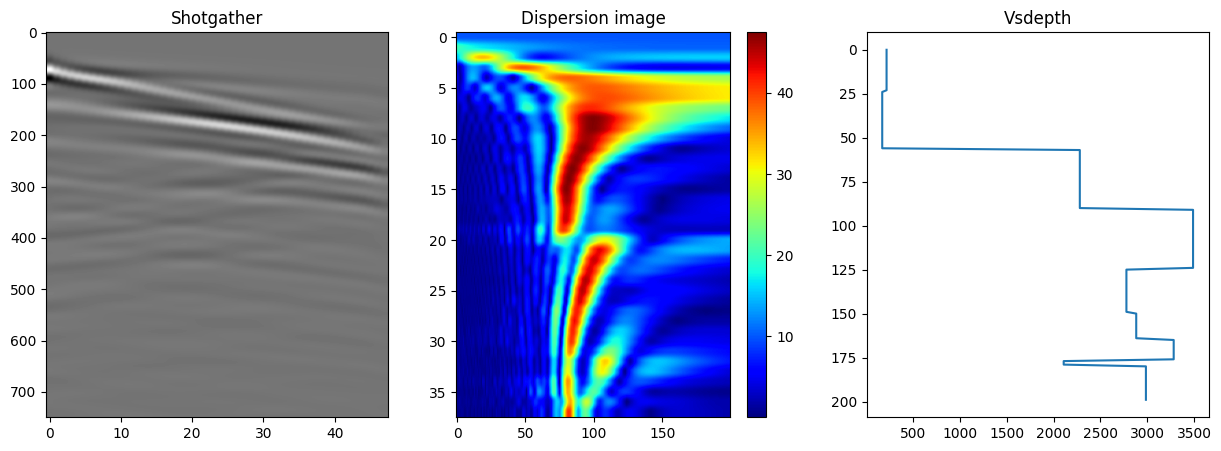

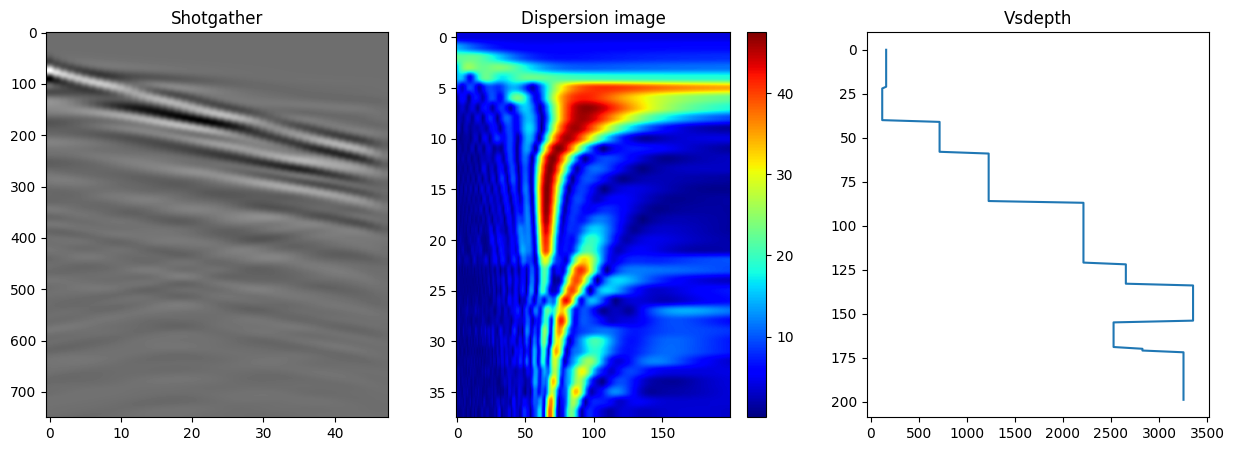

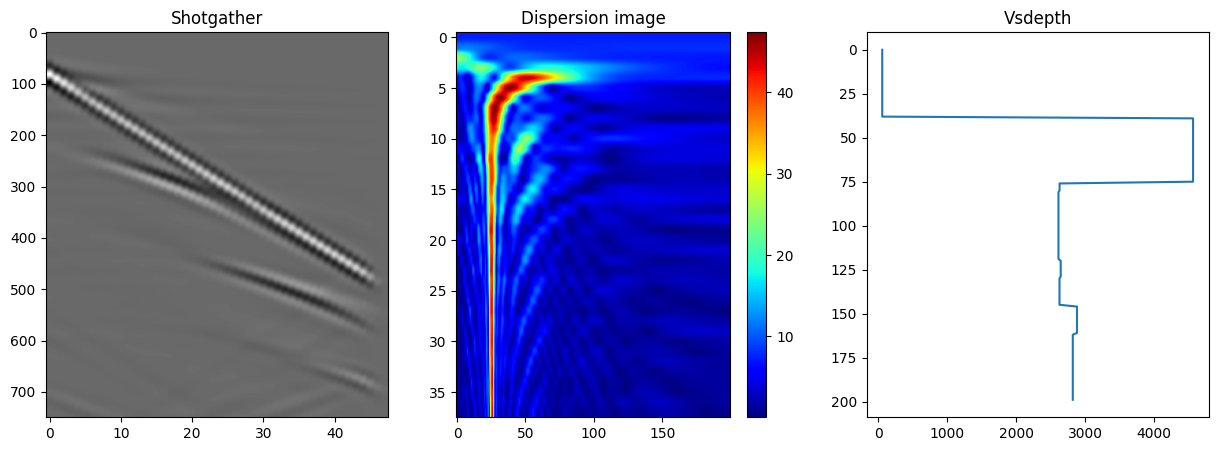

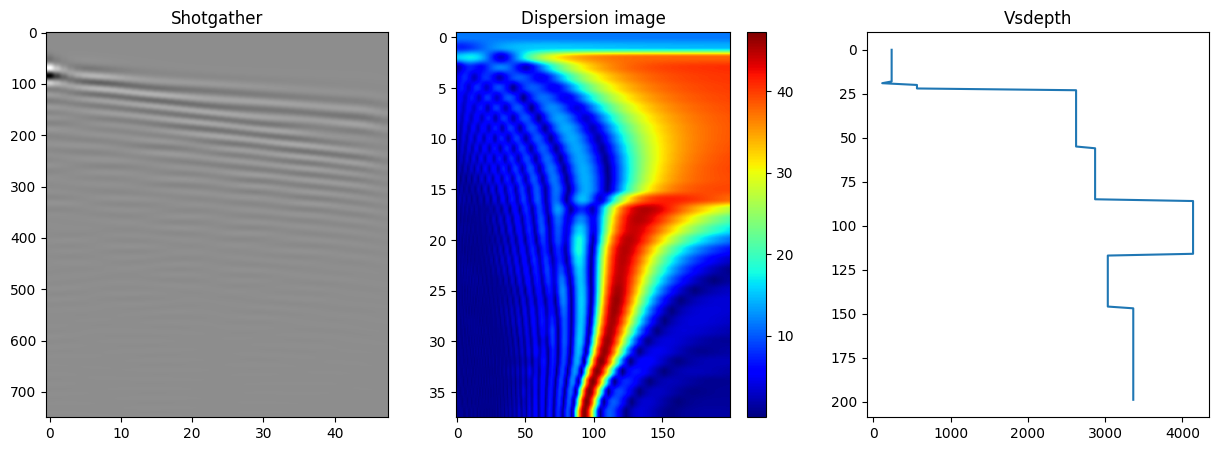

In [120]:
#pour quelques images, afficher dans la premiere colonne le shotgather, dans la deuxieme la dispersion et dans la 3eme la vsdepth:
#prendre 5 images
n=5
for i in range(n):
    sample = train_dataloader.dataset[i]
    image = sample['data']
    label= sample['label']
    #afficher l'image
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image[0].numpy(),aspect='auto',cmap='gray')
    plt.title('Shotgather')
    #calculer la dispersion
    disp = dispersion(image[0].numpy().T, dt, x, c, epsilon=1e-6,fmax=25).numpy().T
    #afficher l'image
    plt.subplot(1,3,2)
    plt.imshow(disp,aspect='auto',cmap='jet')
    plt.colorbar()
    plt.title('Dispersion image')
    #afficher la vsdepth
    plt.subplot(1,3,3)
    plt.plot(label, range(len(label)))
    plt.gca().invert_yaxis()

    plt.title('Vsdepth')
    plt.show()

In [68]:
print(c)


[  50.           94.94949495  139.8989899   184.84848485  229.7979798
  274.74747475  319.6969697   364.64646465  409.5959596   454.54545455
  499.49494949  544.44444444  589.39393939  634.34343434  679.29292929
  724.24242424  769.19191919  814.14141414  859.09090909  904.04040404
  948.98989899  993.93939394 1038.88888889 1083.83838384 1128.78787879
 1173.73737374 1218.68686869 1263.63636364 1308.58585859 1353.53535354
 1398.48484848 1443.43434343 1488.38383838 1533.33333333 1578.28282828
 1623.23232323 1668.18181818 1713.13131313 1758.08080808 1803.03030303
 1847.97979798 1892.92929293 1937.87878788 1982.82828283 2027.77777778
 2072.72727273 2117.67676768 2162.62626263 2207.57575758 2252.52525253
 2297.47474747 2342.42424242 2387.37373737 2432.32323232 2477.27272727
 2522.22222222 2567.17171717 2612.12121212 2657.07070707 2702.02020202
 2746.96969697 2791.91919192 2836.86868687 2881.81818182 2926.76767677
 2971.71717172 3016.66666667 3061.61616162 3106.56565657 3151.51515152
 3196.4

In [65]:
dt

0.02

In [111]:
(1/dt)/2


250.0